In [1]:
!python libraries.py

2024-08-24 17:19:32,787 - INFO - Installation of all libraries completed!


In [2]:
import os
from config import Config

config = Config(
    data_dir='./data',
    train_data_subdir='train/',
    val_data_subdir='test/',
    test_data_subdir='test/'
)

data_dir = ['test', 'train', 'val']
train_data_dir = ['TRAIN_LGHG2@n10degC_to_25degC_Norm_5Inputs.csv']
val_data_dir = ['01_TEST_LGHG2@n10degC_Norm_(05_Inputs).csv', '02_TEST_LGHG2@0degC_Norm_(05_Inputs).csv', '03_TEST_LGHG2@10degC_Norm_(05_Inputs).csv', '04_TEST_LGHG2@25degC_Norm_(05_Inputs).csv']
test_data_dir = ['01_TEST_LGHG2@n10degC_Norm_(05_Inputs).csv', '02_TEST_LGHG2@0degC_Norm_(05_Inputs).csv', '03_TEST_LGHG2@10degC_Norm_(05_Inputs).csv', '04_TEST_LGHG2@25degC_Norm_(05_Inputs).csv']


In [3]:
import pandas as pd
import numpy as np

## Testing Data

In [4]:
test_data_filename = os.listdir(config.get_test_data_dir())[2]
test_data_path = os.path.join(config.get_test_data_dir(), test_data_filename)
test_data = pd.read_csv(test_data_path)
test_data.columns

Index(['V', 'I', 'Temp', 'V_avg', 'I_avg', 'SOC'], dtype='object')

### Extracting Features for Testing
In this cell, we extract specific features from the testing data for use in model testing

In [5]:
X_test = test_data[['V', 'I', 'Temp', 'V_avg', 'I_avg']].values
X_test.shape

(44284, 5)

In [6]:
X_test

array([[0.96801895, 0.74911237, 0.52123591, 0.96801895, 0.74911237],
       [0.96531628, 0.7470984 , 0.52123591, 0.96666762, 0.74810539],
       [0.96519787, 0.74699221, 0.52123591, 0.9661777 , 0.74773433],
       ...,
       [0.33512765, 0.75102009, 0.53256776, 0.32981484, 0.75102009],
       [0.33512765, 0.75102009, 0.53256776, 0.32985141, 0.75102009],
       [0.33512765, 0.75102009, 0.53256776, 0.3298875 , 0.75102009]])

### Extracting Target Variable for Testing

In this cell, we extract the target variable from the testing data

In [7]:
y_test = test_data['SOC'].values
y_test.shape

(44284,)

In [8]:
y_test

array([1.        , 0.99999   , 0.99998333, ..., 0.19499   , 0.19499   ,
       0.19499   ])

In [ ]:
soc_observed = y_test

## Data Normalization

In [9]:
import utils

### Normalizing Feature Data

In this cell, we normalize the feature data for training and validation:
- `normalized_X_train = utils.normalize(X_train)` and `normalized_X_val = utils.normalize(X_val)`
    - Applies normalization to the feature set `X_train` and `X_val` using the `normalize` function from the `utils` module.
    - Normalization typically scales the features to a standard range, improving the performance and convergence of learning algorithms.

This step ensures that the feature data is on a comparable scale, which can be crucial for many learning models.

In [10]:
normalized_X_test = utils.normalize(X_test)
normalized_X_test

array([[ 1.        ,  0.02007657, -1.        ,  1.        ,  0.02007657],
       [ 0.99393247,  0.01412849, -1.        ,  1.        ,  0.01864986],
       [ 0.99559568,  0.01476778, -1.        ,  1.        ,  0.01810358],
       ...,
       [-0.97477332,  1.        , -0.0372726 , -1.        ,  1.        ],
       [-0.97494477,  1.        , -0.03736266, -1.        ,  1.        ],
       [-0.97511403,  1.        , -0.03745156, -1.        ,  1.        ]])

# FNN Testing

In [11]:
from tensorflow import keras
from custom import CustomLeakyReLU, CustomClippedReLU

In [12]:
model_path = './models/dl/soc_estimation_dl.keras'
fnn_model = keras.models.load_model(
    model_path, 
    custom_objects={
        'CustomLeakyReLU': CustomLeakyReLU,
        'CustomClippedReLU': CustomClippedReLU
    }
)

In [13]:
soc_predicted = fnn_model.predict(normalized_X_test)
soc_predicted

1384/1384 ━━━━━━━━━━━━━━━━━━━━ 3s 961us/step


array([[0.9936495 ],
       [0.99297535],
       [0.9933429 ],
       ...,
       [0.20909834],
       [0.20913501],
       [0.20917141]], dtype=float32)

In [14]:
results = fnn_model.evaluate(normalized_X_test, y_test)

1384/1384 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - loss: 0.0054


In [15]:
fnn_metrics = utils.get_metrics(soc_observed, soc_predicted)
fnn_metrics

,Metric,Value
0,max_error,0.273489
1,mean_absolute_error,0.044783
2,mean_absolute_percentage_error,0.087234
3,mean_squared_error,0.004211
4,root_mean_squared_error,0.064893
5,root_mean_squared_log_error,0.040956


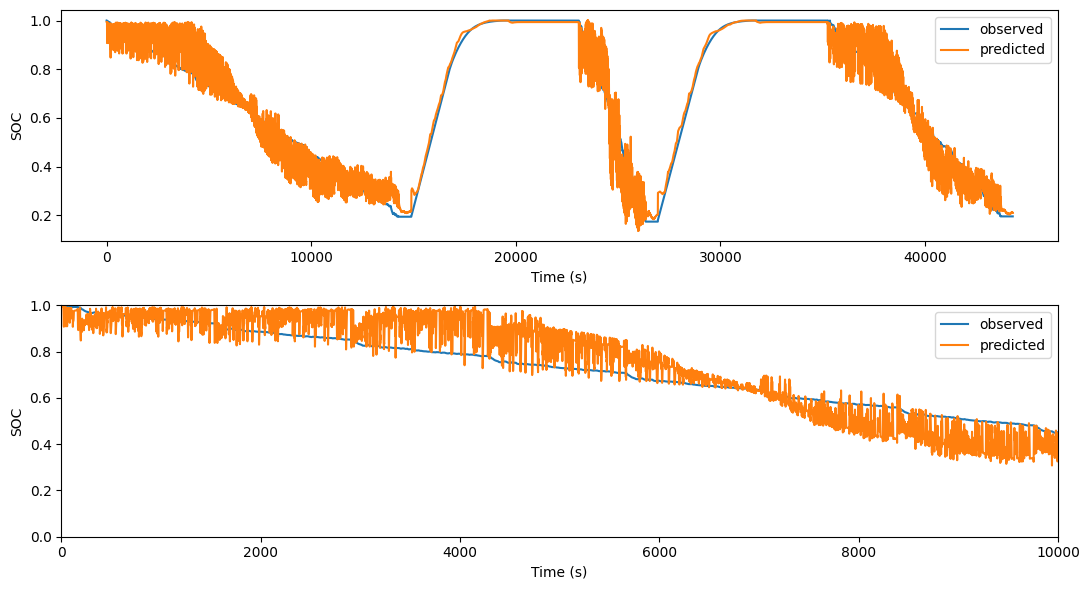

In [16]:
utils.plot_obs_pred(
    y_test=soc_observed, 
    y_predicted=soc_predicted, 
    ylabel='SOC', 
    xlabel='Time (s)'
)